In [1]:
from cluster_model import get_dataset, get_transformer, DATASET_NAME, MODEL_NAME, SEED, N_DATASIZE, get_block_out_label, N_BLOCKS
import cluster_model

ds = get_dataset(DATASET_NAME)
model, _ = get_transformer(MODEL_NAME)
shuffled = ds.shuffle(seed=SEED)['train'][:N_DATASIZE]['text']

ds = shuffled
labs = [get_block_out_label(i) for i in range(N_BLOCKS)]

/home/lev/code/research/ai/lattice_cluster_paths/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
Moving model to device:  cuda


In [2]:
import importlib
importlib.reload(cluster_model)

# TODO: auto sim cutoff needed
decomp = cluster_model.Decomposer(model, ds, labs)
decomp.load()

Creating decomposer with parameter hash bc59bc4fbdc5fbf0582034fc1f46b24d5a7e80f2
Created dataset
Loading dataset from cache
Got embeddings
Loading cluster scores from cache


In [3]:
decomp.lattice_scores[0].shape

(512, 512)

In [4]:
from typing import List
import utils
importlib.reload(utils)
modified_lattice = decomp.lattice_scores.copy()

# TODO: have function which does something like fixing from the a specific neuron?
# Ie have the sub-lattice with only **related** neurons

def cutoff_lattice(lattice: List[List[List[float]]], related_cutoff = 1):
    print(lattice[0].sum())
    r = [(layer > related_cutoff) * layer for layer in lattice]
    print(r[0].sum())
    return r

def create_sublattice(lattice, layer: int, idx_in_layer: int, related_cutoff = 10):
	with_cutoff = cutoff_lattice(lattice, related_cutoff)

LAST_FEAT = 20
modified_lattice = cutoff_lattice(decomp.lattice_scores, related_cutoff=15)

# utils.top_k_dag_paths_dynamic(modified_lattice, k=10_000)

59.51700280064797
0.0


## Isolate Specific Neurons

In [5]:
import numpy as np

def get_weighting_for_layer(layer: int, n_layers: int, weight_decay=0.95, prior_layers_decay=None):
    if prior_layers_decay is None:
        prior_layers_decay = weight_decay
    r = np.ones(n_layers)
    r[layer] = 1
    G = weight_decay
    for i in range(layer):
        r[i] = prior_layers_decay ** (layer - i)
    for i in range(layer + 1, n_layers):
        # Decrease by Gx per layer
        r[i] = G ** (i - layer)
    return r
    

In [6]:
LAYER = 2

In [7]:
import graph
importlib.reload(graph)

# TODO: do this for every neuron in every layer and store
paths = graph.get_feature_paths(decomp.lattice_scores, layer=LAYER, neuron=128, k_search=20, n_max_features=5)

Getting top 20 paths


Got top 20 paths
Trying with cluster diffence cutoff 3
Trying with cluster diffence cutoff 2


In [12]:

import numpy as np
import kernel
from IPython.core.display import display, HTML
from circuitsvis.utils.render import render
importlib.reload(cluster_model)
importlib.reload(utils)
importlib.reload(kernel)
import math

N_CHECK = 2

def get_top_scores(path, layer: int, top_n=100):
    score_path = path
    weighting_per_layer = get_weighting_for_layer(layer, N_BLOCKS, weight_decay=0.5)
    print(weighting_per_layer)
    scores = decomp.score(
        decomp.dataset,
        score_path=score_path,
        weighting_per_layer=weighting_per_layer,
        use_log_scores=True,
        embeds=decomp.ds_emb
    )

    scores_per_token_set = np.array([max(s) for s in scores])
    top_args = np.argsort(scores_per_token_set)[::-1]
    tokens = [[model.tokenizer.decode(t) for t in model.tokenizer(d)[
        'input_ids']] for d in decomp.dataset]
    tokens_reord = [tokens[i] for i in top_args]
    scores_reord = [scores[i] for i in top_args]
    return tokens_reord[:top_n], scores_reord[:top_n]

scores_for_paths = []
for i in range(N_CHECK):
    tokens_reord, scores = get_top_scores(paths[i][0], layer=LAYER, top_n=100)
    print(f"GOT Scores and such for path i")
    scores_for_paths.append((tokens_reord, scores))

/tmp/ipykernel_14039/1441936038.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


[0.25  0.5   1.    0.5   0.25  0.125]
Scoring on 0 of 459325
Scoring on 81920 of 459325
Scoring on 163840 of 459325
Scoring on 245760 of 459325
Scoring on 327680 of 459325
Scoring on 409600 of 459325
GOT Scores and such for path i
[0.25  0.5   1.    0.5   0.25  0.125]
Scoring on 0 of 459325
Scoring on 81920 of 459325


KeyboardInterrupt: 

In [ ]:

def display_top_scores(tokens_reord, scores):
    max_score = max(max(s for s in scores))
    print(max_score)
    act_simp = [[[[((tok) )]]
                 for tok in s] for s in scores]
    html = render(
        "TextNeuronActivations",
        tokens=tokens_reord[:100],
        activations=act_simp[:100],
        firstDimensionName="Layer",
        secondDimensionName="Neuron",
        firstDimensionLabels=None,
        secondDimensionLabels=None
    )
    display(HTML(str(html)))


for i in range(N_CHECK):
    display_top_scores(scores_for_paths[i][0], scores_for_paths[i][1])

41.198668020281


0.9762249708860777


In [ ]:
import math
from IPython.core.display import display, HTML
import math
import numpy as np
from circuitsvis.utils.render import render

# TODO sep fun

/tmp/ipykernel_8787/3797946206.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Look at distributions of scores

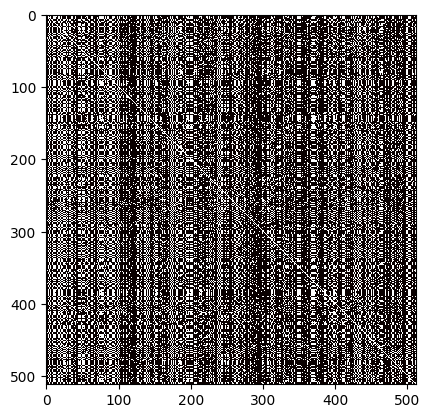

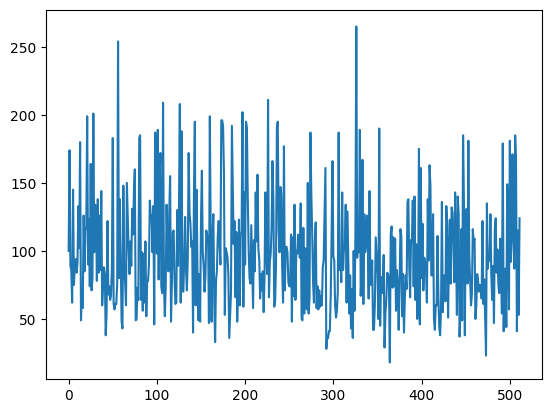

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get distribution of lattice scores

LAYER_START = 4
cutoff = 0.05

# ax = sns.heatmap(decomp.lattice_scores[LAYER_START])
plt.imshow((decomp.lattice_scores[LAYER_START] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

plt.plot((decomp.lattice_scores[3] > cutoff).sum(axis=1))